In [1]:
from datetime import datetime
import osmnx as ox
import geopandas as gpd
import numpy as npm
import matplotlib
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from rtree.index import Index as RTreeIndex
from shapely.geometry import Point
from shapely.geometry import LineString
from shapely.geometry import MultiLineString
from collections import deque
import datetime
import xml.etree.ElementTree as et 
from tqdm import tqdm
import networkx as nx
import json

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
CRS_NYC = 'EPSG:2263'
CRS_LATLON = 'EPSG:4326'
DATA_DIR = '../data'
EXPORTS_DIR = f'{DATA_DIR}/citibike/exports'
EDGE_COUNTS_DIR = f'{EXPORTS_DIR}/edge_counts'

In [3]:
def peek(df):
    display(df.iloc[:3])
    print(len(df))
    
def hash_station_id(station_id):
    try:
        float_id = float(station_id)
        int_id = int(float(station_id))
        if int_id == float_id:
            return str(int_id)
        else:
            return str(float_id)
    except:
        return str(station_id)

In [4]:
LANES_DATE_STRING = '202101'

In [5]:
DATE_STRING = '202110'

In [6]:
edge_count_df = pd.read_csv(f'{EDGE_COUNTS_DIR}/{DATE_STRING}_edge_count.csv')

In [7]:
edge_count_df = edge_count_df.set_index(edge_count_df.columns[0])

In [8]:
def graph_to_node_gdf(G):
    """Converts the given graph to a GeoDataFrame of its nodes."""
    nodes, data = zip(*G.nodes(data=True))
    geom = [Point(node[0], node[1]) for node in nodes]
    nodes_gdf = gpd.GeoDataFrame(data,
                                 index=list(nodes),
                                 crs=CRS_LATLON,
                                 geometry=geom)
    return nodes_gdf

In [9]:
def graph_to_edge_gdf(G):
    """Converts the given graph to a GeoDataFrame of its edges."""
    u, v, data = zip(*G.edges(data=True))
    edges = list(zip(u, v))
    geom = [
        LineString((Point(edge[0][0],
                          edge[0][1]), Point(edge[1][0], edge[1][1])))
        for edge in edges
    ]
    edge_index = [(edge[0] + edge[1]) for edge in edges]
    edges_gdf = gpd.GeoDataFrame(data,
                                 index=edge_index,
                                 crs=CRS_LATLON,
                                 geometry=list(geom))
    edges_gdf['length'] = edges_gdf.geometry.length
    return edges_gdf

In [10]:
lanes_mg = nx.read_shp(f'{DATA_DIR}/geo/lanes/' +
                       f'{LANES_DATE_STRING}_lanes_citibike_area.shp')
lanes_mg.graph['crs'] = CRS_LATLON

# Select only the largest weakly connected component.
lanes_wcc = max(nx.weakly_connected_components(lanes_mg), key=len)
lanes_mg = lanes_mg.subgraph(lanes_wcc)

# Remove directionality due to incorrect infeasible paths!j
lanes_g = nx.Graph(lanes_mg)

In [11]:
node_gdf = graph_to_node_gdf(lanes_g)
edge_gdf = graph_to_edge_gdf(lanes_g)

In [12]:
from ast import literal_eval
edge_count_gdf = edge_count_df.copy()
edge_count_gdf.index = [literal_eval(i) for i in edge_count_df.index]

In [13]:
edge_count_gdf = edge_count_gdf.merge(edge_gdf, left_index=True, right_index=True, how='inner')

In [14]:
edge_count_gdf = edge_count_gdf.sort_values(by=['count'], ascending=False)
edge_count_gdf = gpd.GeoDataFrame(edge_count_gdf, geometry=edge_count_gdf['geometry'], crs=CRS_LATLON)

In [15]:
edge_wbr = edge_count_gdf[edge_count_gdf['street'].str.contains('WILLIAMSBURG BR')]

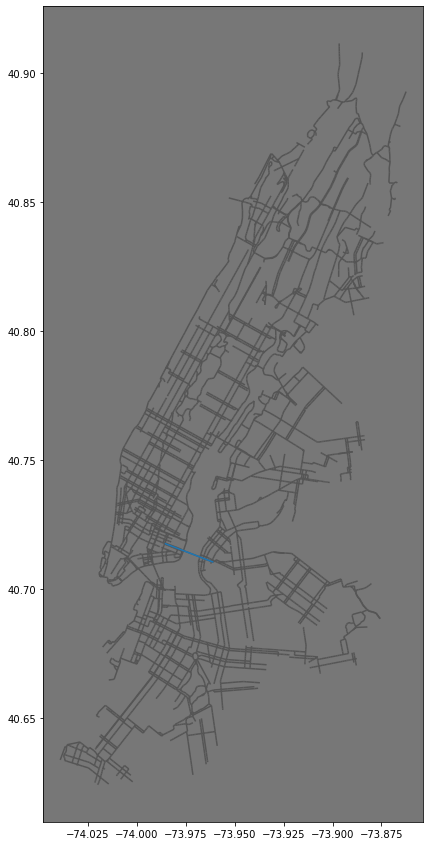

In [16]:
fig, ax = plt.subplots(figsize=(15, 15))
edge_gdf.plot(ax=ax, color='#555', zorder=1)
edge_wbr.plot(ax=ax)
ax.set_facecolor('#777')

In [17]:
date_strings = [
  '201601',
  '201602',
  '201603',
  '201604',
  '201605',
  '201606',
  '201607',
  '201608',
  '201609',
  '201610',
  '201611',
  '201612',
  '201701',
  '201702',
  '201703',
  '201704',
  '201705',
  '201706',
  '201707',
  '201708',
  '201709',
  '201710',
  '201711',
  '201712',
  '201801',
  '201802',
  '201803',
  '201804',
  '201805',
  '201806',
  '201807',
  '201808',
  '201809',
  '201810',
  '201811',
  '201812',
  '201901',
  '201902',
  '201903',
  '201904',
  '201905',
  '201906',
  '201907',
  '201908',
  '201909',
  '201910',
  '201911',
  '201912',
  '202001',
  '202002',
  '202003',
  '202004',
  '202005',
  '202006',
  '202007',
  '202008',
  '202009',
  '202010',
  '202011',
  '202012',
]

In [18]:
counts = {
    'date': [],
    'count': [],
}
counts_df = pd.DataFrame(counts)

wbr_counts = {
    'date': [],
    'count': [],
}

In [19]:
for date_string in tqdm(date_strings):
    edge_count_df = pd.read_csv(f'{EDGE_COUNTS_DIR}/{date_string}_bridge_area_edge_count.csv')
    edge_count_df = edge_count_df.set_index(edge_count_df.columns[0])
    edge_count_df.index = [literal_eval(i) for i in edge_count_df.index]
    edge_count_df = edge_count_df.merge(edge_gdf, left_index=True, right_index=True, how='inner')
    edge_wbr = edge_count_df[edge_count_df['street'].str.contains('WILLIAMSBURG BR')]
    count = edge_wbr.iloc[0]['count']
    
    wbr_counts['date'].append(date_string)
    wbr_counts['count'].append(count)
    
    count_df = edge_count_df[['count']]
    count_df = count_df.reset_index()
    count_df['date'] = date_string
    count_df = count_df.rename(columns={'index': 'edge'})
    counts_df = counts_df.append([count_df])

100%|██████████| 60/60 [00:05<00:00, 10.37it/s]


In [38]:
edge_wbr

,count,segmentid,street,analyze,index_righ,ct2010,boro_code,ShpName,Wkb,Wkt,Json,geometry,length
"(-73.9857663407635, 40.717723676073476, -73.96093753412293, 40.71047194328312)",2164,238645.0,WILLIAMSBURG BR,1,36270,001200,1,202101_lanes_citibike_area,b'\x00\x00\x00\x00\x02\x00\x00\x00-\xc0R\x7f\x...,LINESTRING (-73.9857663407635 40.7177236760735...,"{ ""type"": ""LineString"", ""coordinates"": [ [ -73...","LINESTRING (-73.98577 40.71772, -73.96094 40.7...",0.025866


In [20]:
peek(counts_df)

,date,count,edge
0,201601,1144.0,"(-74.01739796592196, 40.70845740998238, -74.01..."
1,201601,1144.0,"(-74.01695833805474, 40.70905766172049, -74.01..."
2,201601,1144.0,"(-74.01676485998686, 40.7093330258103, -74.016..."


263898


In [21]:
def get_date_from_date_string(date_string):
    year = int(date_string[0:4])
    month = int(date_string[4:])
    return datetime.datetime(year, month, 1)

In [22]:
wbr_counts_df = pd.DataFrame(wbr_counts)
wbr_counts_df['date'] = wbr_counts_df['date'].apply(lambda x: get_date_from_date_string(x))
wbr_counts_df = wbr_counts_df.set_index(wbr_counts_df['date'])
wbr_counts_df = wbr_counts_df.drop(columns=['date'])

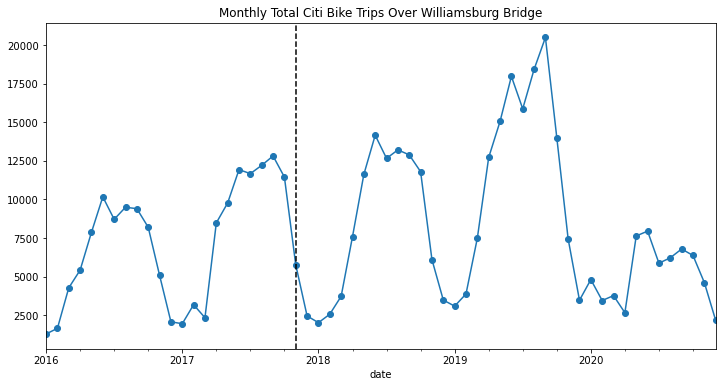

In [23]:
fig, ax = plt.subplots(figsize=(12, 6))
wbr_counts_df.plot(ax=ax, marker='o', legend=None)
ax.set_title('Monthly Total Citi Bike Trips Over Williamsburg Bridge')
ax.axvline(datetime.datetime(2017, 11, 17), linestyle='--', color='#000')
plt.show()

In [24]:
def get_date_string_from_date_text(date_text):
    months = [
        'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct',
        'Nov', 'Dec'
    ]
    month = months.index(date_text[0:3]) + 1
    return f'20{date_text[4:]}{month}'

In [25]:
totals_df = pd.read_csv(f'{DATA_DIR}/citibike/csv/citibike_totals.csv', header=None)
totals_df.columns = ['date', 'count']
totals_df['date'] = totals_df['date'].apply(lambda x: get_date_from_date_string(get_date_string_from_date_text(x)))
totals_df = totals_df.set_index(totals_df['date'])
totals_df = totals_df.drop(columns=['date'])
totals_df['count'] = totals_df['count'].str.replace(',', '').astype(int)
peek(totals_df)

,count
date,
2015-11-01,987259
2015-12-01,804112
2016-01-01,509478


72


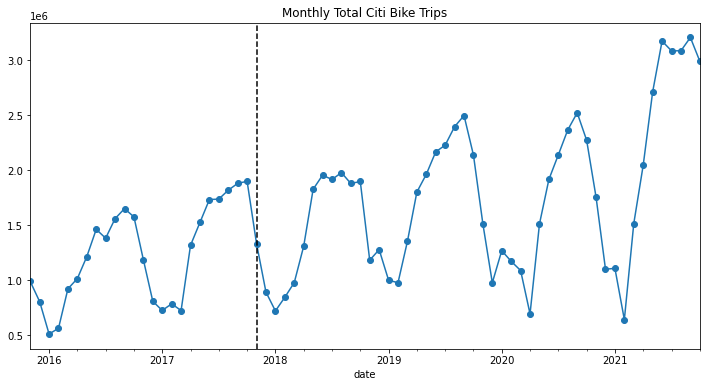

In [26]:
fig, ax = plt.subplots(figsize=(12, 6))
totals_df.plot(ax=ax, marker='o', legend=None, color='C0')
ax.set_title('Monthly Total Citi Bike Trips')
ax.axvline(datetime.datetime(2017, 11, 17), linestyle='--', color='#000')
plt.show()

In [27]:
date_strings
for date_string in tqdm(date_strings):
    edge_count_df = pd.read_csv(f'{EDGE_COUNTS_DIR}/{date_string}_bridge_area_edge_count.csv')
    

In [27]:
wbr_pct_df = wbr_counts_df.merge(totals_df, left_index=True, right_index=True, how='inner')
wbr_pct_df['pct'] = wbr_pct_df['count_x'] / wbr_pct_df['count_y']
peek(wbr_pct_df)

,count_x,count_y,pct
date,,,
2016-01-01,1280,509478,0.002512
2016-02-01,1645,560865,0.002933
2016-03-01,4271,919911,0.004643


60


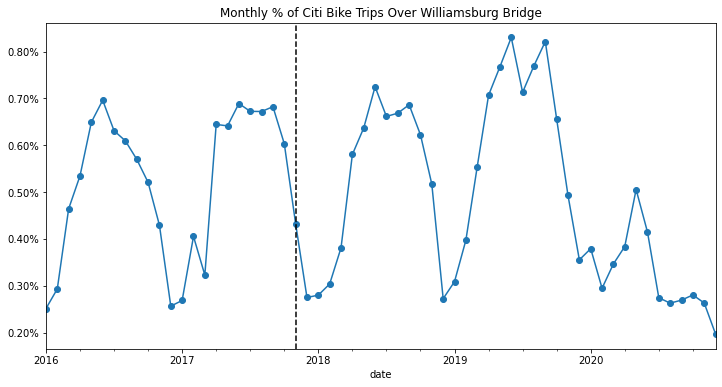

In [28]:
fig, ax = plt.subplots(figsize=(12, 6))
wbr_pct_df['pct'].plot(ax=ax, marker='o', legend=None)
ax.set_title('Monthly % of Citi Bike Trips Over Williamsburg Bridge')
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0, decimals=2))
ax.axvline(datetime.datetime(2017, 11, 17), linestyle='--', color='#000')
plt.show()

In [29]:
wbr_pct_df = wbr_pct_df.rename(columns={
    'count_x': 'bridge',
    'count_y': 'total',
})

In [30]:
wbr_pct_df[['bridge_1', 'total_1']] = wbr_pct_df[['bridge', 'total']].shift(12)
wbr_pct_df['bridge_diff'] = wbr_pct_df['bridge'] - wbr_pct_df['bridge_1']
wbr_pct_df['total_diff'] = wbr_pct_df['total'] - wbr_pct_df['total_1']
wbr_pct_df['bridge_pct'] = wbr_pct_df['bridge_diff'] / wbr_pct_df['total_diff']

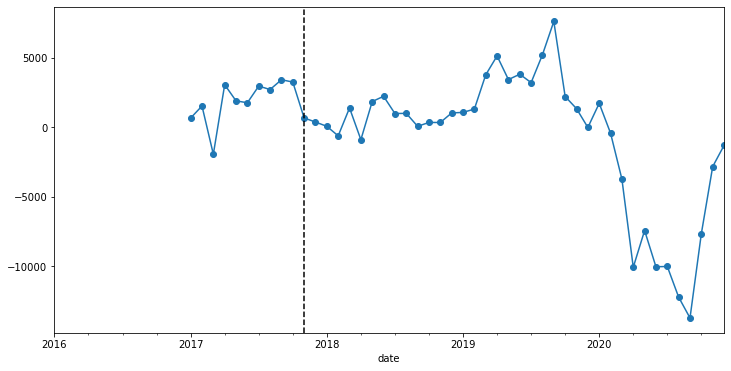

In [31]:
fig, ax = plt.subplots(figsize=(12, 6))
wbr_pct_df['bridge_diff'].plot(ax=ax, marker='o', legend=None)
#ax.set_title('Monthly % of Citi Bike Trips Over Williamsburg Bridge')
ax.axvline(datetime.datetime(2017, 11, 17), linestyle='--', color='#000')
plt.show()

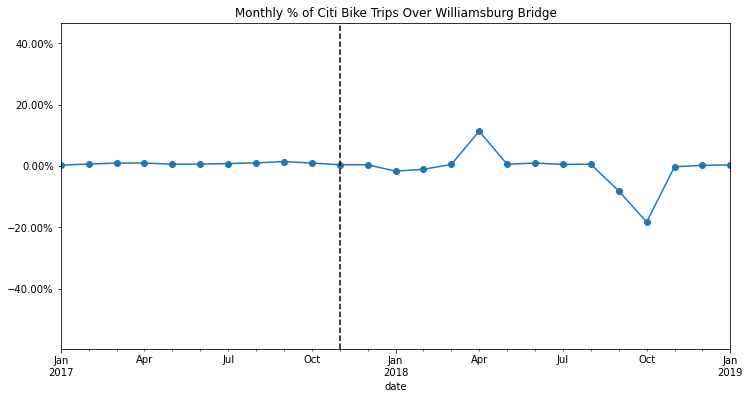

In [32]:
fig, ax = plt.subplots(figsize=(12, 6))
wbr_pct_df['bridge_pct'].plot(ax=ax, marker='o', legend=None)
ax.set_title('Monthly % of Citi Bike Trips Over Williamsburg Bridge')
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0, decimals=2))
ax.axvline(datetime.datetime(2017, 11, 17), linestyle='--', color='#000')
ax.set_xlim([
    datetime.datetime(2017, 1, 1),
    datetime.datetime(2019, 1, 1),
])
plt.show()

In [33]:
pct_df = edge_count_df.merge(totals_df, left_index=True, right_index=True, how='inner')
pct_df['pct'] = pct_df['count_x'] / pct_df['count_y']

In [34]:
pct_df

,count_x,segmentid,street,analyze,index_righ,ct2010,boro_code,ShpName,Wkb,Wkt,Json,geometry,length,count_y,pct


In [35]:
min_counts_df = counts_df.groupby(by=['edge']).agg({'count': 'min'})
max_counts_df = counts_df.groupby(by=['edge']).agg({'count': 'max'})
diff_counts_df = max_counts_df - min_counts_df
diff_counts_df = diff_counts_df.sort_values(by=['count'], ascending=False)
peek(diff_counts_df)

,count
edge,
"(-73.98950693735173, 40.736010971055684, -73.98993297698847, 40.735427532268325)",43334.0
"(-73.9899704341117, 40.73537089179311, -73.98993297698847, 40.735427532268325)",43334.0
"(-73.98927648016964, 40.736323751994384, -73.98907932805653, 40.73659131752902)",41568.0


4999


In [36]:
diff_counts_edf = diff_counts_df.copy()
diff_counts_edf = diff_counts_edf.reset_index()
diff_counts_edf['geometry'] = diff_counts_edf['edge'].apply(lambda x: LineString((Point(x[0], x[1]), Point(x[2], x[3]))))
diff_counts_gdf = gpd.GeoDataFrame(diff_counts_edf, crs=CRS_LATLON)
diff_counts_gdf

,edge,count,geometry
0,"(-73.98950693735173, 40.736010971055684, -73.9...",43334.0,"LINESTRING (-73.98951 40.73601, -73.98993 40.7..."
1,"(-73.9899704341117, 40.73537089179311, -73.989...",43334.0,"LINESTRING (-73.98997 40.73537, -73.98993 40.7..."
2,"(-73.98927648016964, 40.736323751994384, -73.9...",41568.0,"LINESTRING (-73.98928 40.73632, -73.98908 40.7..."
3,"(-73.99033070314395, 40.73713186005657, -73.98...",41568.0,"LINESTRING (-73.99033 40.73713, -73.98908 40.7..."
4,"(-73.98950693735173, 40.736010971055684, -73.9...",41568.0,"LINESTRING (-73.98951 40.73601, -73.98928 40.7..."
...,...,...,...
4994,"(-73.9412724921811, 40.72336496744797, -73.940...",2.0,"LINESTRING (-73.94127 40.72336, -73.94032 40.7..."
4995,"(-73.95529376485396, 40.75719893793579, -73.95...",2.0,"LINESTRING (-73.95529 40.75720, -73.95526 40.7..."
4996,"(-73.93891183823231, 40.72357882496601, -73.93...",2.0,"LINESTRING (-73.93891 40.72358, -73.93849 40.7..."
4997,"(-73.94056279664314, 40.79318791536382, -73.93...",1.0,"LINESTRING (-73.94056 40.79319, -73.93819 40.7..."


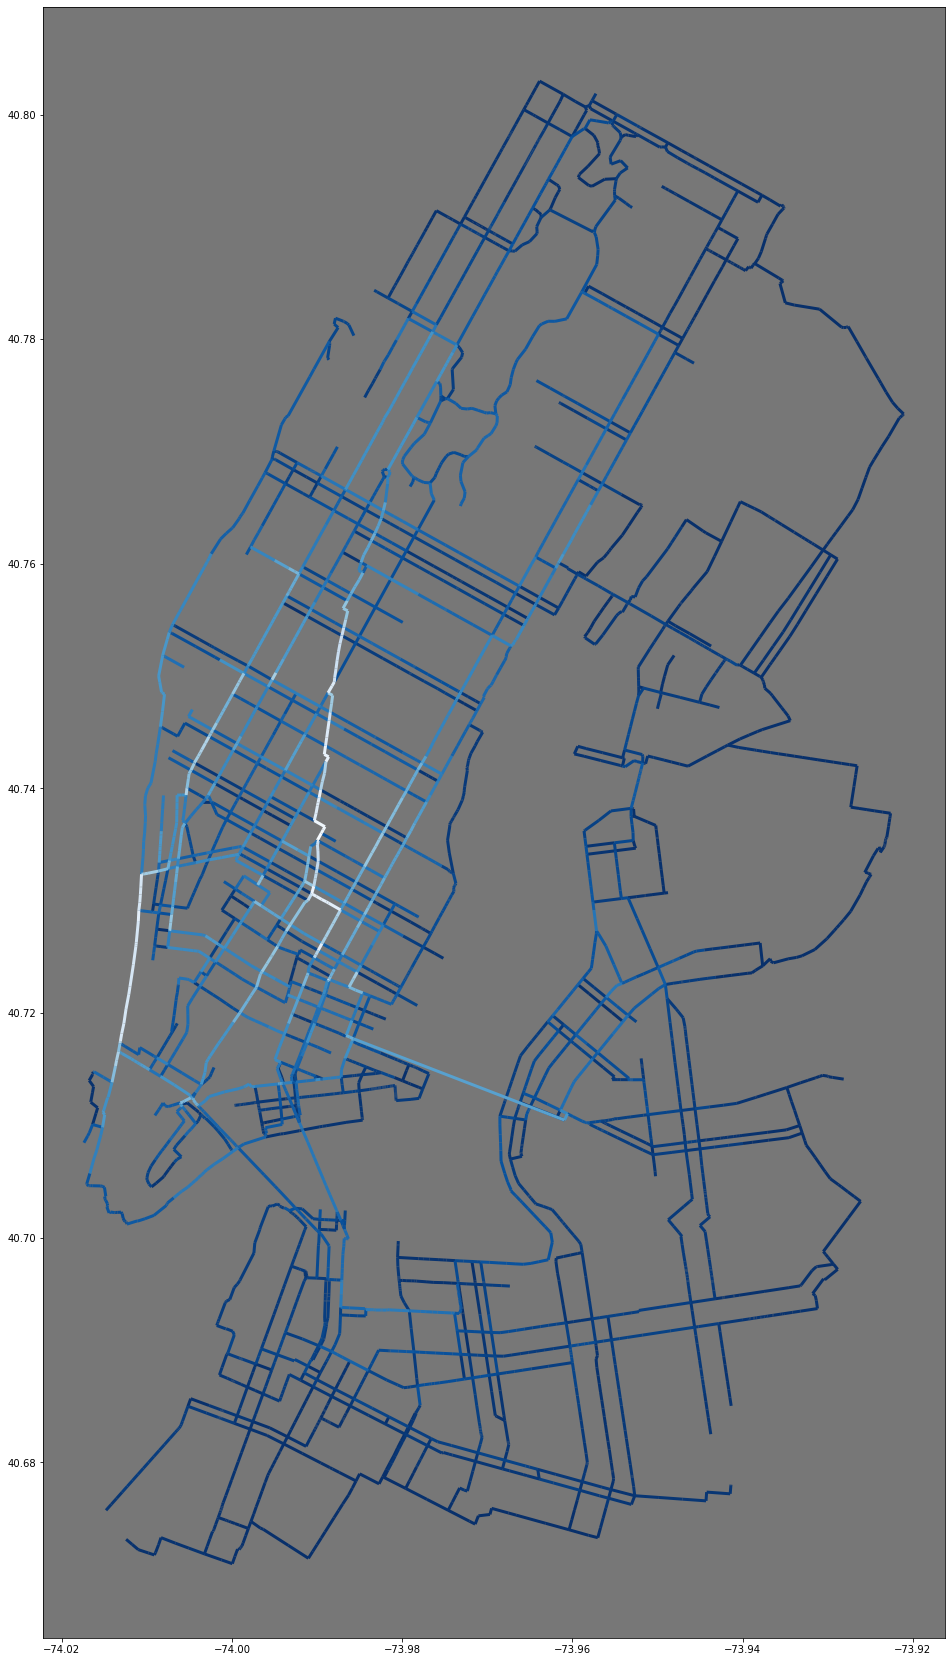

In [37]:
fig, ax = plt.subplots(figsize=(30, 30))
diff_counts_gdf.sort_values(by=['count']).plot(ax=ax, cmap='Blues_r', column='count', zorder=3, linewidth=3)
ax.set_facecolor('#777')